In [1]:
#mlp_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#9 July 2018
#
#train an mlp model on the XO dataset, this executes in 14 minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate training and validation data
N_dots = 10000000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
validate = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
9999995,9999995,4.463069,1.803710,4.813767,0.384071,X,1.0,0.0,0.0
9999996,9999996,2.502623,-5.257549,5.822795,-1.126528,B,0.0,0.0,1.0
9999997,9999997,9.548941,2.224772,9.804686,0.228903,B,0.0,0.0,1.0
9999998,9999998,-8.296504,-2.182905,8.578872,-2.884312,B,0.0,0.0,1.0
9999999,9999999,1.413923,-4.494418,4.711579,-1.266004,B,0.0,0.0,1.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

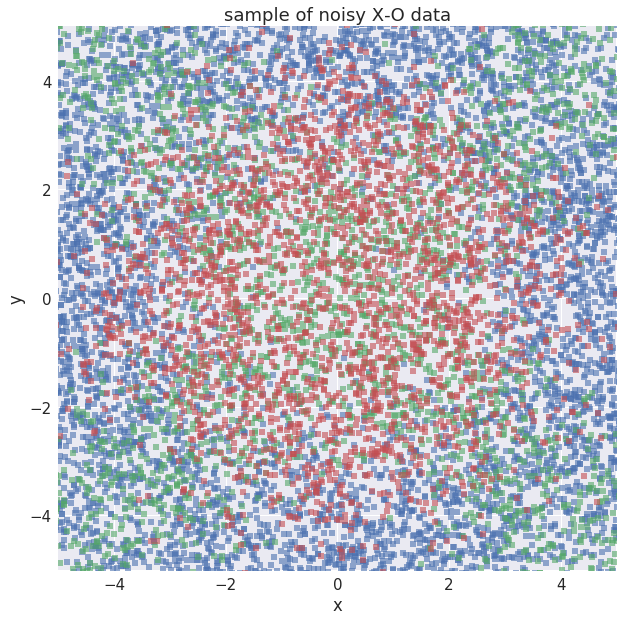

In [6]:
#scatterplot of noisy X-O data
N_plot = 20000
df = train.sample(n=N_plot)
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/training_data.png')

In [7]:
#note class imbalance in training data
train.groupby('class')['id'].count()

class
B    7376405
O    1265851
X    1357744
Name: id, dtype: int64

In [8]:
#rebalance training data & randomize records
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num')
print train_balanced.groupby('class')['id'].count()
train_balanced.head()

class
B    1265851
O    1265851
X    1357744
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
7006388,7006388,1.384860,1.759842,2.239393,0.904080,X,1.0,0.0,0.0,3.251161e-08
1230195,1230195,7.898361,-0.518581,7.915367,-0.065563,B,0.0,0.0,1.0,3.680895e-07
5714398,5714398,-5.152859,4.450838,6.808958,2.429164,B,0.0,0.0,1.0,4.113167e-07
354886,354886,-3.082106,-6.895367,7.552845,-1.991138,B,0.0,0.0,1.0,5.577195e-07
9674206,9674206,1.102980,4.001413,4.150647,1.301828,O,0.0,1.0,0.0,7.142443e-07


In [9]:
#rebalance validation data
df = validate
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
validate_balanced = df.sort_values('ran_num')
print validate_balanced.groupby('class')['id'].count()
validate_balanced.head()

class
B    1268839
O    1268839
X    1359270
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
4878529,4878529,-1.807039,-0.499446,1.874790,-2.871935,O,0.0,1.0,0.0,1.549436e-08
1928145,1928145,1.970480,-1.488657,2.469593,-0.646999,O,0.0,1.0,0.0,4.722298e-07
2290541,2290541,-3.264099,1.883507,3.768546,2.618229,X,1.0,0.0,0.0,7.276863e-07
884531,884531,1.791818,-3.953361,4.340470,-1.145252,O,0.0,1.0,0.0,9.484941e-07
945490,945490,-3.205213,1.761278,3.657252,2.639130,O,0.0,1.0,0.0,1.272242e-06


In [10]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x_train = train_balanced[x_cols].values
y_train = train_balanced[y_cols].values
print x_train.shape, y_train.shape
x_val = validate_balanced[x_cols].values
y_val = validate_balanced[y_cols].values
print x_val.shape, y_val.shape

N_classes =  3
(3889446, 2) (3889446, 3)
(3896948, 2) (3896948, 3)


In [11]:
#this helper function assembles a simple MLP classifier
def mlp_classifier(layers, dropout_fraction=None):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation
    model = Sequential()
    #input layer
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    if (dropout_fraction):
        model.add(Dropout(dropout_fraction))
    #hidden layers
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
        if (dropout_fraction):
            model.add(Dropout(dropout_fraction))
    #output layer
    N = layers[-1]
    model.add(Dense(N, activation='linear'))
    #model.add(Dense(N, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [12]:
#build MLP classification model 
N_inputs = x_train.shape[1]
N_middle = 300*N_inputs*N_classes
N_outputs = N_classes
layers = [N_inputs, 10, 60, 20, N_outputs]
dropout_fraction = 0.1
print 'layers = ', layers
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
model.summary()

layers =  [2, 10, 60, 20, 3]
dropout_fraction =  0.1


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1220      
__________

In [13]:
#fit model to the training data...takes several minute on m4.xl instance...this demo needsa gpu!!!
from time import time
#from keras.callbacks import TensorBoard
#tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
N_training_epochs = 40
batch_size = 10000
time_start = tm.time()
#model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_val, y_val))
#    , callbacks=[tensorboard])

final validation loss =  0.15318789922831094
dropout_fraction =  0.1


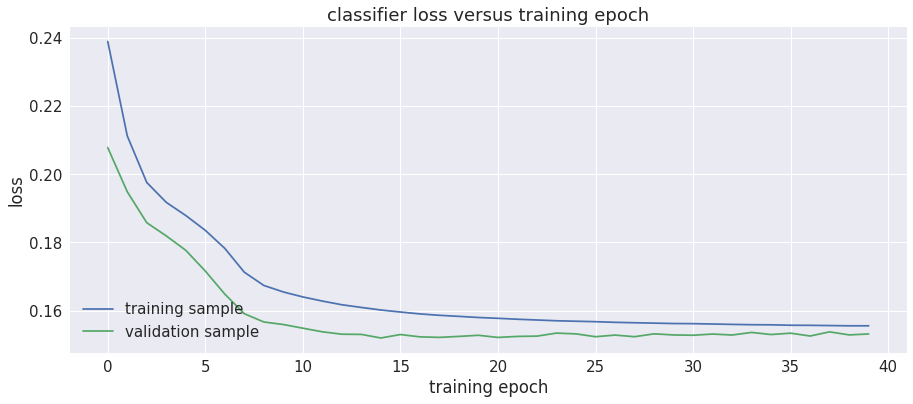

In [14]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]
print 'dropout_fraction = ', dropout_fraction

In [15]:
#generate class predictions on another sample of X-O data
N_dots = 20000
xy = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = xy[x_cols].values
y = xy[y_cols].values
y_pred = model.predict(x)
#normalize class scores
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    xy[y_col] = y_pred[:, idx]
xy['sum'] = xy.O_score + xy.X_score + xy.B_score
for y_col in y_cols:
    xy[y_col] /= xy['sum']
xy['sum'] = xy.O_score + xy.X_score + xy.B_score
idx = (xy.O_score > xy.X_score) & (xy.O_score > xy.B_score)
xy.loc[idx, 'class_pred'] = 'O'
idx = (xy.X_score > xy.B_score) & (xy.X_score > xy.O_score)
xy.loc[idx, 'class_pred'] = 'X'
idx = (xy.B_score > xy.O_score) & (xy.B_score > xy.X_score)
xy.loc[idx, 'class_pred'] = 'B'
xy.head(5)

/usr/local/lib/python2.7/dist-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


,id,x,y,r,angle,class,X_score,O_score,B_score,sum,class_pred
record,,,,,,,,,,,
0,0,-6.389267,1.322418,6.524686,2.937500,B,0.067096,0.096873,0.836030,1.0,B
1,1,3.035695,-1.373303,3.331878,-0.424835,O,0.466058,0.442787,0.091155,1.0,X
2,2,6.211622,3.423825,7.092731,0.503761,B,0.319862,0.077981,0.602158,1.0,B
3,3,-1.468991,1.434957,2.053542,2.367914,X,0.434441,0.583866,-0.018307,1.0,O
4,4,4.569460,-6.765465,8.164036,-0.976765,X,0.396401,0.092811,0.510788,1.0,B


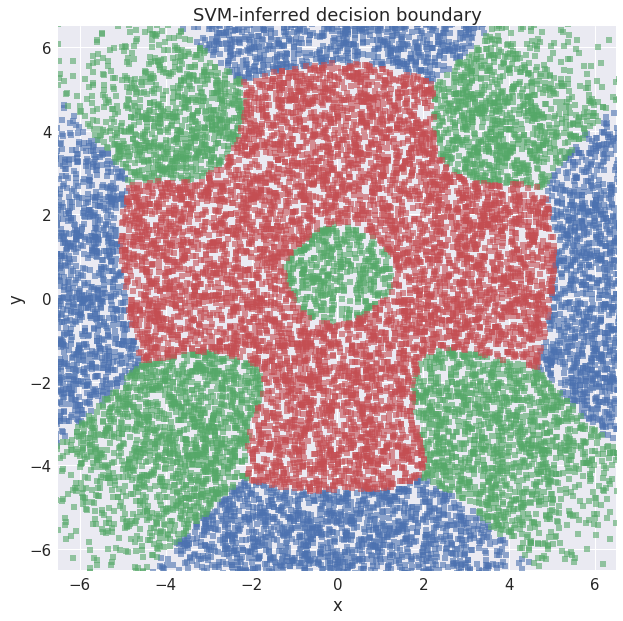

In [16]:
#scatterplot showing model's predicted decision boundaries
df = xy
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('SVM-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/mlp_decision_boundary.png')

In [17]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  13.7733533859
